# Collaborative filtering using K-Nearest Neighbors (KNN) approach

## Import packages

In [ ]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise import KNNWithMeans
from surprise import Reader, Dataset
from collections import defaultdict
from sklearn.metrics import precision_recall_curve

In [ ]:
!pip install scikit-surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 13.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3095474 sha256=0a53966523e99a4668b11dbc58a7df8cabc4351215163afc85508dbb26e104f1
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


## Mount drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Set directory

In [ ]:
%cd /content/drive/MyDrive/SINA

/content/drive/MyDrive/SINA


## Unzip data

In [ ]:
!unzip /content/drive/MyDrive/SINA/ml-latest-small.zip

Archive:  /content/drive/MyDrive/SINA/ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


## Load data

In [ ]:
links = pd.read_csv('/content/drive/MyDrive/SINA/ml-latest-small/links.csv')
movies = pd.read_csv('/content/drive/MyDrive/SINA/ml-latest-small/movies.csv')
ratings = pd.read_csv('/content/drive/MyDrive/SINA/ml-latest-small/ratings.csv')
tags = pd.read_csv('/content/drive/MyDrive/SINA/ml-latest-small/tags.csv')

In [ ]:
links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB


In [ ]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [ ]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [ ]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


## Data preprocessing

In [ ]:
# Merging movies and ratings dataframes
df = pd.merge(movies,ratings,on='movieId')

# Preview the new dataframe
df.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483


In [ ]:
np.random.seed(42)

In [ ]:
from surprise import Reader, Dataset

# Reader class is used to parse a file containing ratings
reader = Reader(rating_scale=(1, 5))
# The columns must correspond to user id, item id and ratings (in that order)
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

## Calculate cosine similarities

In [ ]:
from surprise import KNNWithMeans

# To use user-based cosine similarity
sim_options = {
    "name": "cosine",
    "user_based": True,  # Compute  similarities between users
}
# Use user_based true/false to switch between user-based or item-based collaborative filtering
algo = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': True})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


## Function for recommendation

In [ ]:
def recommend_movies(user_id, n=3):
    # Get a list of all movie ids
    all_movie_ids = df['movieId'].unique()
    # Get a list of ids that the user has rated
    rated_movies = df.loc[df['userId']==user_id, 'movieId']
    # Remove the rated movies for the recommendations
    unrated_movies = [m for m in all_movie_ids if m not in rated_movies]
    
    # Predict ratings for all unrated movies
    predictions = []
    for movie_id in unrated_movies:
        predictions.append(algo.predict(user_id, movie_id))
    
    # Sort the predictions by highest rating
    predictions.sort(key=lambda x: x.est, reverse=True)
    
    # Get the top n predictions
    top_n_predictions = predictions[:n]
    
    recommended_movies = []
    for prediction in top_n_predictions:
        movie_title = df.loc[df['movieId'] == prediction.iid, 'title'].unique()[0]
        recommended_movies.append((movie_title, prediction.est))
    
    return recommended_movies

## Recommendation result

In [ ]:
user_id = 1
recommend_movies(user_id)

[('Persuasion (1995)', 5),
 ('Cry, the Beloved Country (1995)', 5),
 ('Usual Suspects, The (1995)', 5)]

RMSE Metrics

In [ ]:
from surprise import accuracy
from surprise.model_selection import train_test_split

# Split data into train and test sets
trainset, testset = train_test_split(data, test_size=0.2)

# Train the algorithm on the trainset
algo.fit(trainset)

# Predict ratings for the testset
predictions = algo.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)


Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.8945


0.8945102014264995

RMSE (Root Mean Squared Error): The RMSE of the predictions is 0.8922. This metric tells us how close the predicted ratings are to the actual ratings. The lower the RMSE, the better the performance of the model. In this case, on average, the predicted ratings are about 0.89 units away from the actual ratings. As the ratings range from 1 to 5, an RMSE of 0.8922 is considered fairly good.

## Precision & Recall metrics

In [ ]:
from collections import defaultdict

def precision_recall_at_k(predictions, k=10, threshold=3.5):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls

# Calculate precision and recall
precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=4)

# Precision and recall can then be averaged over all users
print("Precision: ", sum(prec for prec in precisions.values()) / len(precisions))
print("Recall: ", sum(rec for rec in recalls.values()) / len(recalls))


Precision:  0.8079638752052556
Recall:  0.30536736813978044


The precision value is 0.8079 , which means that 80.79% of the recommended items are relevant. This is a high precision value, indicating that the model is good at recommending items that users will like.

The recall value is 0.3053. This means that 30.53% of the relevant items were recommended. In other words, out of all the items that a user would have liked, the model recommended about 30.53% of them. This is relatively low, suggesting that the model might be missing out on a significant number of items that users would have liked.

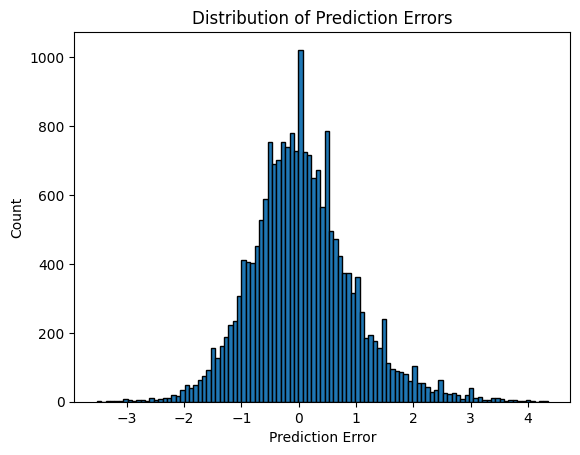

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_curve

# Compute the prediction errors
errors = [pred.est - pred.r_ui for pred in predictions]

# Plot the histogram of errors
plt.hist(errors, bins='auto', histtype='bar', ec='black') 
plt.title('Distribution of Prediction Errors')
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.show()

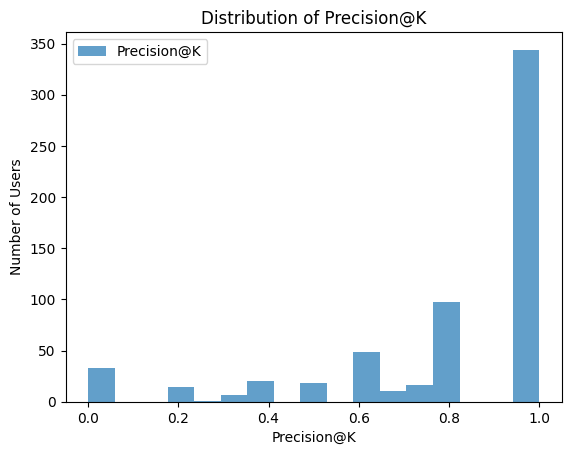

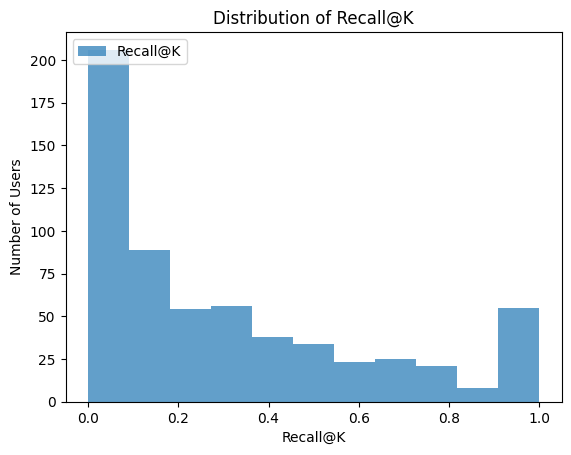

In [ ]:
# Using the function defined earlier to get precision and recall for each user
precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=4)

# Plotting precision@k
plt.hist(list(precisions.values()), bins='auto', alpha=0.7, label='Precision@K')
plt.title('Distribution of Precision@K')
plt.xlabel('Precision@K')
plt.ylabel('Number of Users')
plt.legend(loc='upper left')
plt.show()

# Plotting recall@k
plt.hist(list(recalls.values()), bins='auto', alpha=0.7, label='Recall@K')
plt.title('Distribution of Recall@K')
plt.xlabel('Recall@K')
plt.ylabel('Number of Users')
plt.legend(loc='upper left')
plt.show()


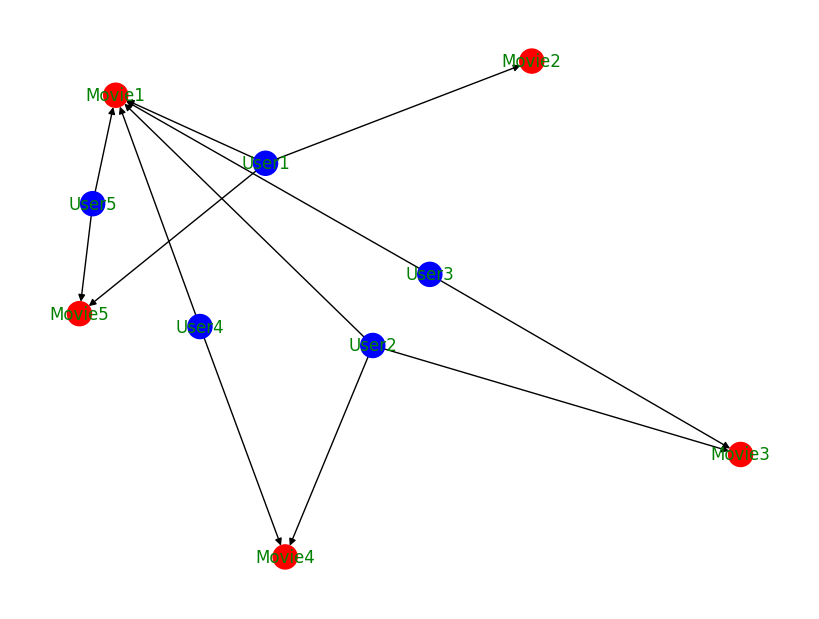

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a new directed graph
G = nx.DiGraph()

# Add nodes for users and movies
# For simplicity, let's take 5 users and a few of their rated movies
users = ['User1', 'User2', 'User3', 'User4', 'User5']
movies = ['Movie1', 'Movie2', 'Movie3', 'Movie4', 'Movie5']

G.add_nodes_from(users, color='blue')
G.add_nodes_from(movies, color='red')

# Add edges representing ratings
# Just creating some example ratings here
ratings = [('User1', 'Movie1'), ('User1', 'Movie2'), ('User2', 'Movie1'), 
           ('User3', 'Movie3'), ('User4', 'Movie4'), ('User5', 'Movie5'),
           ('User2', 'Movie3'), ('User2', 'Movie4'), ('User1', 'Movie5'),
           ('User3', 'Movie1'), ('User4', 'Movie1'), ('User5', 'Movie1')]

G.add_edges_from(ratings)

# Draw the graph
plt.figure(figsize=(8,6))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color=['blue']*5 + ['red']*5, font_color='green')
plt.show()


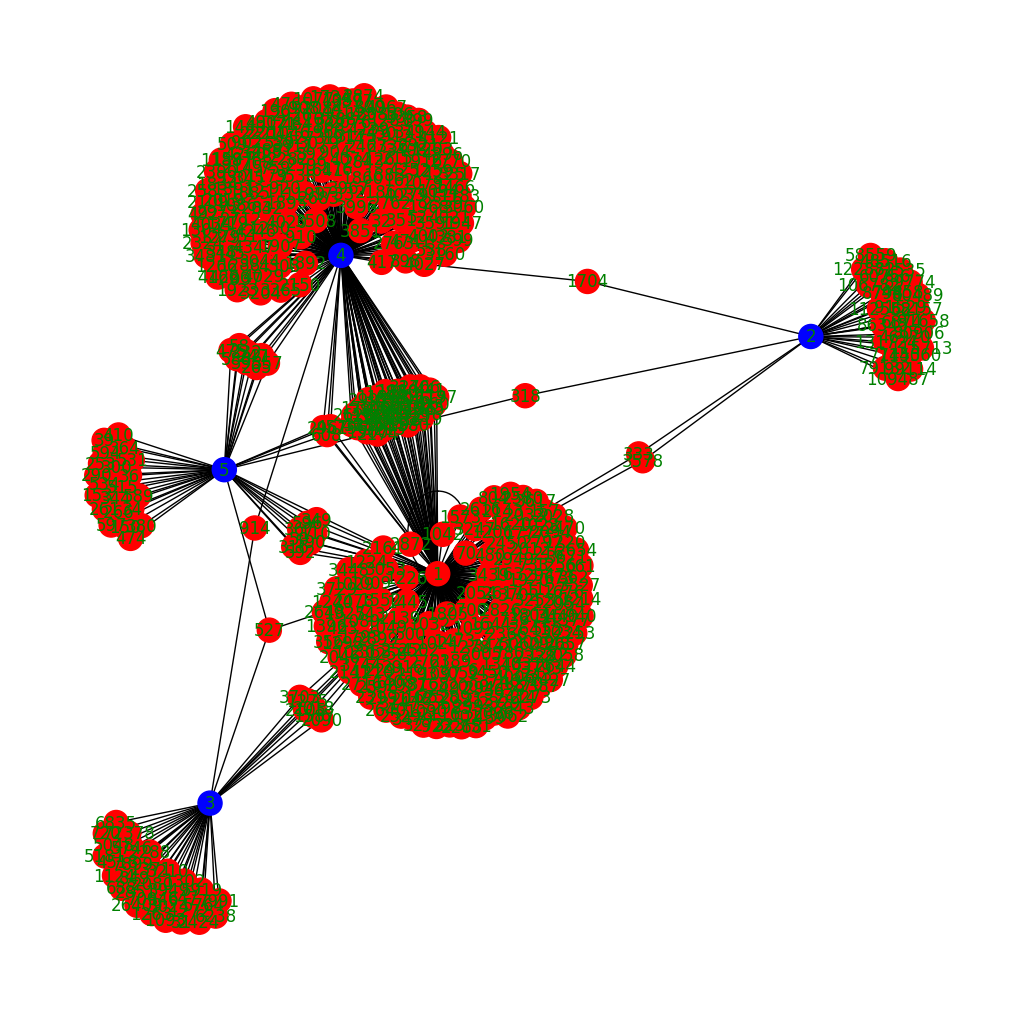

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Assume the CSV files are located in the same directory
ratings_G = pd.read_csv('/content/drive/MyDrive/SINA/ml-latest-small/ratings.csv')

# Create a new graph
G = nx.Graph()

# Pick first 5 users
user_ids = [1, 2, 3, 4, 5]

# Add nodes for the selected users
for user_id in user_ids:
    G.add_node(user_id, color='blue')

    # Get all movies rated by this user
    user_movies = ratings_G[ratings_G['userId'] == user_id]['movieId'].unique()

    # Add nodes for the movies
    G.add_nodes_from(user_movies, color='red')

    # Add edges between the user and the movies they've rated
    for movie_id in user_movies:
        G.add_edge(user_id, movie_id)

# Draw the graph
colors = nx.get_node_attributes(G, 'color').values()
plt.figure(figsize=(10, 10))
nx.draw(G, node_color=colors, with_labels=True, font_color='green')
plt.show()
